In [70]:
import numpy as np
import yaml
import os
import shutil
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt

# 目标时间步数
lists = [0,10,100, 500, 1000, 2000, 5000, 10000,20000, 50000] # 5000, 10000, 50000

# 读取初始参数
with open('/home/wsy/Acc_MC/MC_sim/paras.yaml', 'r') as f:
    config = yaml.safe_load(f)
R_sh = float(config['R_sh'])
GM0 = float(config['GM0'])
eta = float(config['eta'])
beta_min = float(config['beta_min'])
B0 = float(config['B0'])
xi = float(config['xi'])
Lam_max = float(config['Lam_max'])
g_me0 = float(config['g_me0']) 
r0 = float(config['r0'])
n_p = float(config['n_p'])
mode = float(config['mode'])

N_par = int(config['N_par']) # 粒子数
N_time = int(float((config['N_time']))) # 时间步数
N_bins = config['N_bins'] # 时间步长

jet_type = config['type']
syn = config['SYN_flag']
SA = config['SA_flag']
Sh = config['Shear_flag']
ESC = config['ESC_flag']

lgRsh = float(np.log10(R_sh))
lgLam = float(np.log10(Lam_max))
lgr0 = float(np.log10(r0))

config = {
    'log R_sh': lgRsh,
    'GM0': GM0,
    'eta': eta,
    'B0': B0,
    'xi': xi,
    'log Lam_max': lgLam,
    'gme0': g_me0,
    'number density for protons': n_p,
    'log r0': lgr0,
    'Type': jet_type,
    'Particle numbers': N_par,
    'Step numbers': N_time,
    'Step length': N_bins,
    'Whether esc': ESC,
    'SYN': syn,
    'SA': SA,
    'Sh': Sh
}


if jet_type=='kolgv': 
    q = 5/3
elif jet_type=='Bohm':
    q = 1
elif jet_type=='HS':
    q = 2


# 读取npy文件
# 随机行走模式
if mode == 0:
    output_dir = '/home/wsy/Acc_MC/Results/trial_RW/'
    type = 'RW'
# 小角散射模式
elif mode ==1:
    output_dir = '/home/wsy/Acc_MC/Results/trial_Rotation/'
    type = 'smallAngle_Rot'
# 速度变化下的随机行走
elif mode ==2:
    output_dir = '/home/wsy/Acc_MC/Results/trial_Rotation_RW/'
    type = 'RW_Rot'
elif mode ==3:
    output_dir = '/home/wsy/Acc_MC/Results/trial_Drag/'
    type = 'RW_Drag'
    
acc_type = 'All'

if (SA == True) and (Sh == False):
    acc_type = 'SAOnly'
elif (SA == False) and (Sh == True):
    acc_type = 'ShOnly'

name = type + '_' + acc_type + '_' + jet_type
# 保存配置文件
run_id = '%s_%s_%s_%s_%s'%(lgRsh, GM0, B0, xi, n_p)
tar_dir = f'/home/wsy/Acc_MC/figures/{run_id}_{name}/'

if os.path.exists(tar_dir):
    shutil.rmtree(tar_dir)   # 删除已有的文件夹
os.makedirs(tar_dir)
    
with open(os.path.join(tar_dir, 'config_record.yaml'), 'w') as f:
    yaml.dump(config, f)

file1 = np.load(output_dir + 'gme_jetL.npy')
file2 = np.load(output_dir +'gme_obsL.npy')
file3 = np.load(output_dir +'r_jetL.npy')
file4 = np.load(output_dir +'t_jetL.npy')
file5 = np.load(output_dir +'t_obsL.npy')
file6 = np.load(output_dir +'x_jetL.npy')
file7 = np.load(output_dir +'y_jetL.npy')
file8 = np.load(output_dir +'z_jetL.npy')

print(file1[:,-1])

if (np.min(file1[:,-1]) == -1):
    print('逃逸发生')
else:
    print('没有逃逸')
    ESC = False

[106.70512081 101.2922381  103.89021185 ... 100.54813322  97.55802599
 103.00789676]
没有逃逸


In [71]:
m_e = (const.m_e.cgs).value
m_p = (const.m_p.cgs).value
e = (const.e.esu).value
c = (const.c.cgs).value
pi = np.pi
r_e = e**2/(m_e*c**2) 
sigma_e = 8*pi/3*r_e**2

def beta_dis(r, GM_0, r_max):
    r1 = eta*r_max
    beta_max = np.sqrt(1-1/GM_0**2)
    if np.abs(r)<r1:
        return beta_max
    elif np.abs(r)>r_max:
        return 0.0
    else:
        return beta_max + ((beta_min-beta_max)/(r_max-r1))*(np.abs(r)-r1)

# 散射时标
def T_sc(B0,gme):
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    t_sc = A_sc*gme**(2-q)
    return t_sc

# 同步辐射能损
def T_cool(B0,gme):
    A2 = (sigma_e*np.square(B0))/(6*pi*m_e*c)
    t_cool = (A2*gme)**(-1)
    return t_cool

# 扩散逃逸时标
def T_esc(B0,gme):
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    A3 = ((3*np.square(R_sh))/(2*np.square(c)))*A_sc**(-1)
    t_esc = A3*gme**(q-2)
    return t_esc

# 随机加速时标
def T_SA(B0, n_p, gme):
    rg = gme*m_e*c**2/(e*B0)
    ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2) # 相对喷流随动系的Alfven波波速
    Dpp = xi * ba**2 / (1 - ba**2) * g_me0**2 * c / rg**(2 - q) / Lam_max**(q - 1) # Dpp
    tacc = g_me0**2 / Dpp
    return tacc

# NR剪切加速时标
def T_sh(B0,gme):
    beta0 = beta_dis(0,GM0,R_sh) #中心流速
    beta = beta_dis(r0,GM0,R_sh) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Delta_r = rate*R_sh
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    Gamma_j4 = 1/(1-beta**2)**2
    A1=(2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*A_sc
    t_sh = 2*gme**(q-2)/(A1*(6-q))
    return t_sh

# 回旋半径
def rg(B0,gme):
    return gme*m_e*c**2/(e*B0)

# Alfven波波速
def Alf_beta(B0):
    ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2)
    return ba

0.002182708264139581


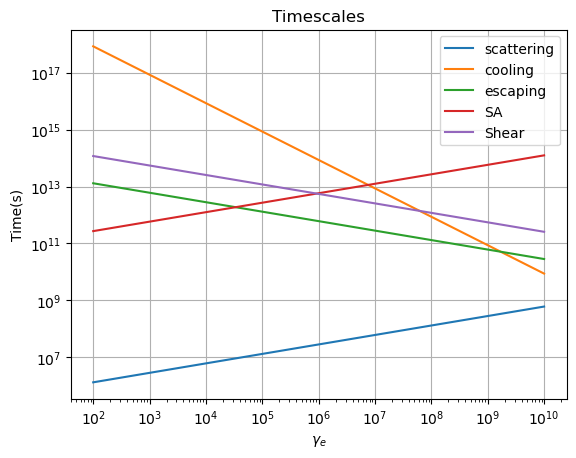

In [72]:
gme_list = np.logspace(2,10,80)
t_sc = T_sc(B0,gme_list)
t_cool = T_cool(B0,gme_list)
t_esc = T_esc(B0,gme_list)
t_acc = T_SA(B0,n_p,gme_list)
t_sh = T_sh(B0,gme_list)
rg = rg(B0, gme_list)
ba = Alf_beta(B0)
print(ba)
#print(c*t_sc)
#print(rg)
plt.title('Timescales')
plt.plot(gme_list,t_sc,label='scattering')
plt.plot(gme_list,t_cool,label = 'cooling')
plt.plot(gme_list,t_esc,label = 'escaping')
plt.plot(gme_list,t_acc,label='SA')
plt.plot(gme_list,t_sh,label='Shear')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\gamma_e$')
plt.ylabel('Time(s)')
plt.grid(True)
plt.legend()
plt.savefig(tar_dir + 'timescales.png')
plt.show()

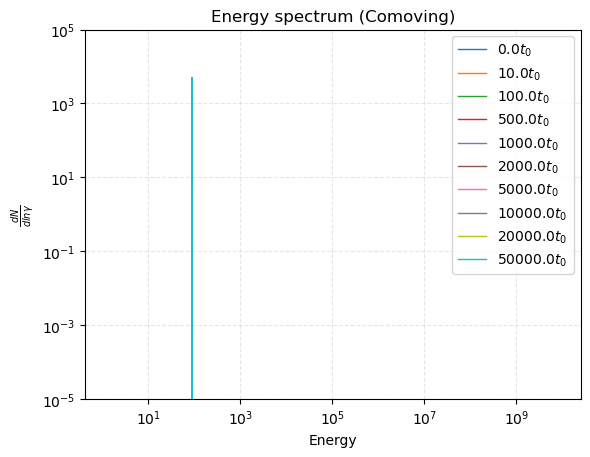

In [73]:
# 共动系能谱演化
# 假设 g_me0 是包含1000个粒子能量的数组
# 过滤掉非正值（因为 log 坐标要求数据 > 0）
for i in lists:
    g_me = file1[:,i]
    g_me = g_me[g_me > 0]
    bins = np.logspace(np.min(np.log10(1e0)), np.max(np.log10(1e10)), 50)
    counts, bin_edges = np.histogram(g_me, bins=bins)
    N_tau = i/N_bins
    # 计算每个区间的中心点（用于绘图）
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, markersize=4, linewidth=1, label=r'%s$t_0$ '%N_tau)
plt.title('Energy spectrum (Comoving)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel(r'$\frac{dN}{dln \gamma}$')
#plt.title('Log-Log Energy Spectrum of 1000 Particles')
plt.ylim(1e-5,1e5)
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.savefig(tar_dir + 'spec_comv.png')
plt.show()

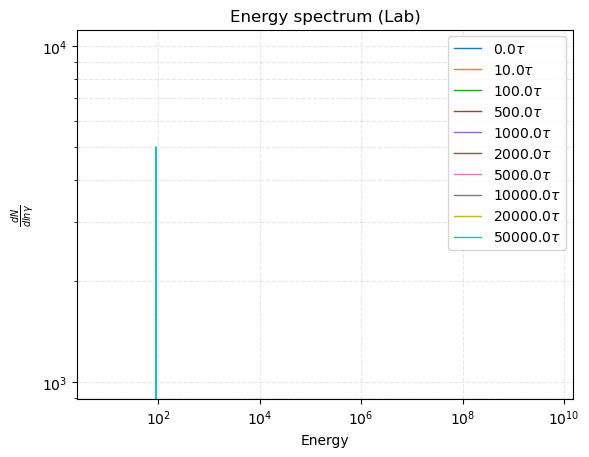

In [74]:
# 实验室系能谱演化
for i in lists:
    g_me = file2[:,i]
    g_me = g_me[g_me > 0]
    bins = np.logspace(np.log10(1e0), np.log10(1e10), 10)
    counts, bin_edges = np.histogram(g_me, bins=bins)
    N_tau = i/N_bins
    # 计算每个区间的中心点（用于绘图）
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(bin_centers, counts, markersize=4, linewidth=1, label=r'%s$\tau$ '%N_tau)
plt.title('Energy spectrum (Lab)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy')
plt.ylabel(r'$\frac{dN}{dln \gamma}$')
#plt.title('Log-Log Energy Spectrum of 1000 Particles')
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.savefig(tar_dir + 'spec_lab.png')
plt.show()

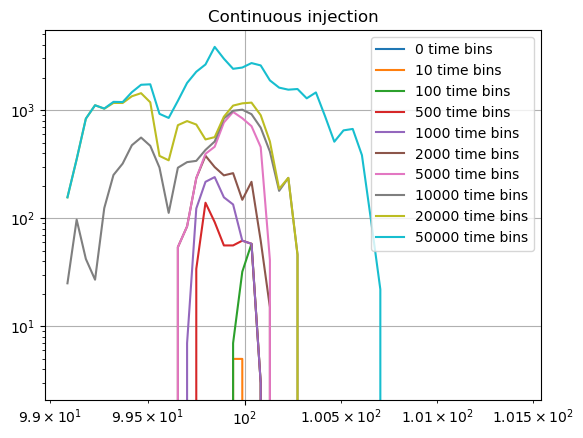

In [75]:
# 连续注入粒子谱
# 对于任意粒子，记录其关于时间的演化
N_bins = 50
All_gme = file1  # Assuming file1 is a NumPy array with the data
par1_gme = All_gme[100, :]
par1_gme = par1_gme[par1_gme > 0]  # Filter positive values
# Create logarithmic bins
gme_bins = np.logspace(np.log10(np.min(par1_gme)), np.log10(np.max(par1_gme)), N_bins + 1)
# Time points to evaluate
# Plotting
plt.figure()
for i in lists:
    n_spec, _ = np.histogram(par1_gme[:i], bins=gme_bins)
    plt.plot(gme_bins[:-1], n_spec, label=f'{i} time bins')
# Set log scales and add grid/legend
plt.title('Continuous injection')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.savefig(tar_dir + 'conti_inject.png')
plt.show()

[[-1.55054636e-10  2.31864331e-03  4.03792899e-03 ... -6.49233881e-03
   8.95240844e-03 -4.01782006e-03]
 [-1.55054636e-10  2.08280601e-03  2.29738560e-03 ...  3.29316193e-03
   3.58183092e-03 -3.39824074e-03]
 [-1.55054636e-10 -7.44503050e-03 -7.45187205e-03 ... -1.86103713e-03
   6.08750920e-04  4.92532242e-03]
 ...
 [-1.55054636e-10  9.40806600e-03  9.62337074e-03 ...  4.94117415e-03
  -3.58350542e-03 -3.57719515e-03]
 [-1.55054636e-10  3.25901261e-03  7.63570239e-03 ...  9.06382988e-03
   2.54538815e-03  2.57082734e-03]
 [-1.55054636e-10  1.04220095e-03  1.46428043e-03 ... -7.46642863e-03
   6.35754453e-03  6.35238795e-03]]
[[1282324.89926409 1282324.89926409 1282324.89926409 ... 1282324.89926147
  1282324.89926147 1282324.89926147]
 [1282324.89926409 1282324.89926409 1282324.89926409 ... 1282324.89926147
  1282324.89926147 1282324.89926147]
 [1282324.89926409 1282324.89926409 1282324.89926409 ... 1282324.89926147
  1282324.89926147 1282324.89926147]
 ...
 [1282324.89926409 1282324

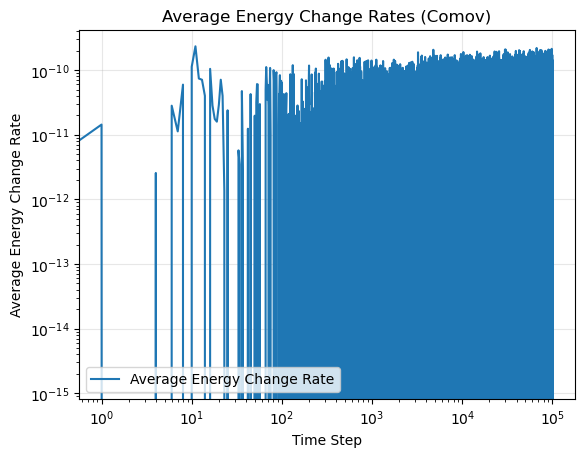

In [76]:
# 共动系平均能量变化率
g_me = file1
t_jetL = file4

# 按列求差
delta_gm = np.diff(g_me,axis=1)
delta_t = np.diff(t_jetL,axis=1)
print(delta_gm)
print(delta_t)
# 按时间步计算有效平均值
avg_energy_rate = []
for t in range(delta_t.shape[1]):
    mask_t = delta_t[:, t] > 0  # 当前时间步的mask
    valid_gm = delta_gm[mask_t, t]
    valid_t = delta_t[mask_t, t]
    if len(valid_t) > 0:
        energy_rate = valid_gm / valid_t
        avg_energy_rate.append(np.mean(energy_rate))
    else:
        avg_energy_rate.append(np.nan)  # 处理无数据情况

avg_energy_rate = np.array(avg_energy_rate)
time_steps = np.arange(avg_energy_rate.shape[0])

# 绘图部分保持不变
plt.plot(time_steps, avg_energy_rate, label='Average Energy Change Rate')
#print(avg_energy_rate)
plt.xlabel('Time Step')
plt.ylabel('Average Energy Change Rate')
plt.title('Average Energy Change Rates (Comov)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(tar_dir + 'energy_rates.png')
plt.show()

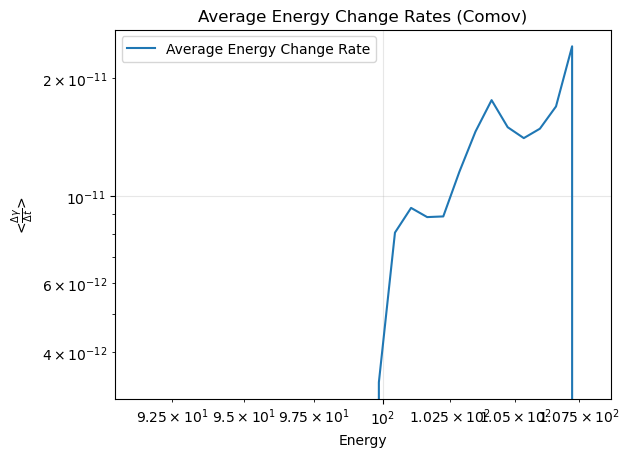

In [77]:
# 按时间步计算有效平均值
avg_energy_rate_list=[]
gme_cut = g_me[:,0:-1]
gmes = np.logspace(np.log10(np.min(g_me)),np.log10(np.max(g_me)),30)
Delta = delta_gm/delta_t
for i in range(len(gmes)-1):
    mask = ((gme_cut)>=gmes[i]) & ((gme_cut)<=gmes[i+1])
    valid_Delta = Delta[mask]
    if valid_Delta.size >= 0:
        avg_energy_rate = np.mean(valid_Delta)
        avg_energy_rate_list.append(avg_energy_rate)
    else:
        avg_energy_rate_list.append(np.nan)

# 绘图部分保持不变
plt.plot(gmes[0:-1], avg_energy_rate_list, label='Average Energy Change Rate')
#print(avg_energy_rate)
plt.xlabel('Energy')
plt.ylabel(r'<$\frac{\Delta \gamma}{\Delta t}$>')
plt.title('Average Energy Change Rates (Comov)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(tar_dir + 'energy_rates.png')
plt.show()

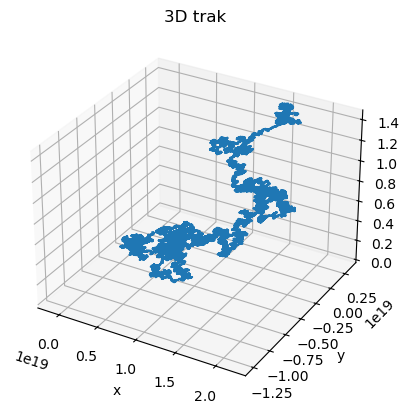

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


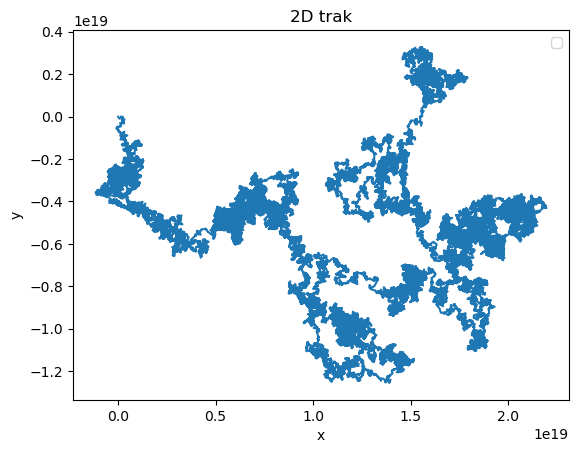

In [78]:
i = 1
mask = (file6[i,:] < 10*R_sh)
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection = '3d')
ax1.plot(file6[i,:][mask], file7[i,:][mask],file8[i,:][mask])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('3D trak')
plt.savefig(tar_dir + '3D_traks.png')
plt.show()

fig2,ax2 = plt.subplots()
ax2.plot(file6[i,:][mask], file7[i,:][mask])
#ax2.scatter(file6[i,:][mask], file7[i,:][mask])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D trak')
plt.legend()
plt.savefig(tar_dir + '2D_traks.png')
plt.show()

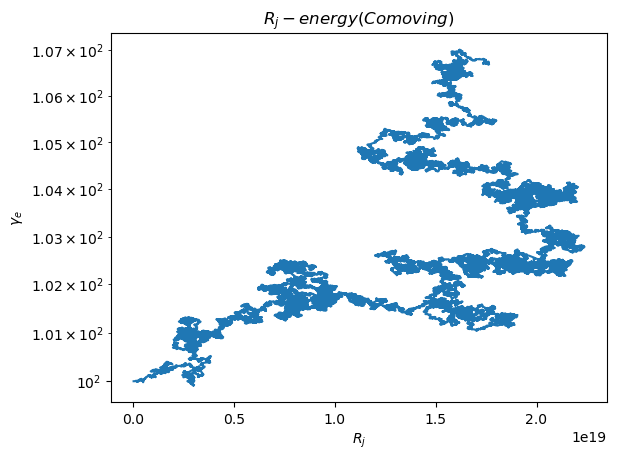

In [79]:
gme_j = file1[0,:]
mask = np.where(gme_j>0)
r_L = file3[1,:]
plt.plot(r_L[mask],gme_j[mask])
#plt.xlim(1e0,1e13)
plt.title(r'$R_{j} - energy (Comoving)$')
plt.yscale('log')
plt.xlabel(r'$R_j$')
plt.ylabel(r'$\gamma_e$')
plt.savefig(tar_dir + 'gamma-radius.png')
plt.show()
#plt.scatter(r_L,gme_j)
#print(gme_j)
#print(r_L)


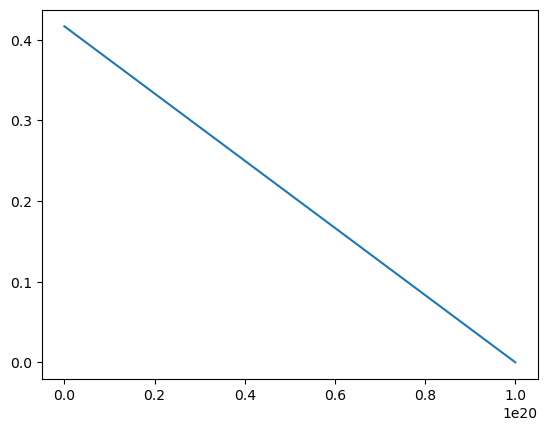

In [80]:
def beta_dis(r, GM_0, r_max):
    r1 = eta*r_max
    beta_max = np.sqrt(1-1/GM_0**2)
    if np.abs(r)<r1:
        return beta_max
    elif np.abs(r)>r_max:
        return 0.0
    else:
        return beta_max + ((beta_min-beta_max)/(r_max-r1))*(np.abs(r)-r1)
    
r = np.logspace(-2,np.log10(R_sh),201)
beta = []
for i in r:
    betai = beta_dis(i,GM0,R_sh)
    beta.append(betai)
plt.plot(r,beta)
#plt.xscale('log')
#plt.yscale('log')

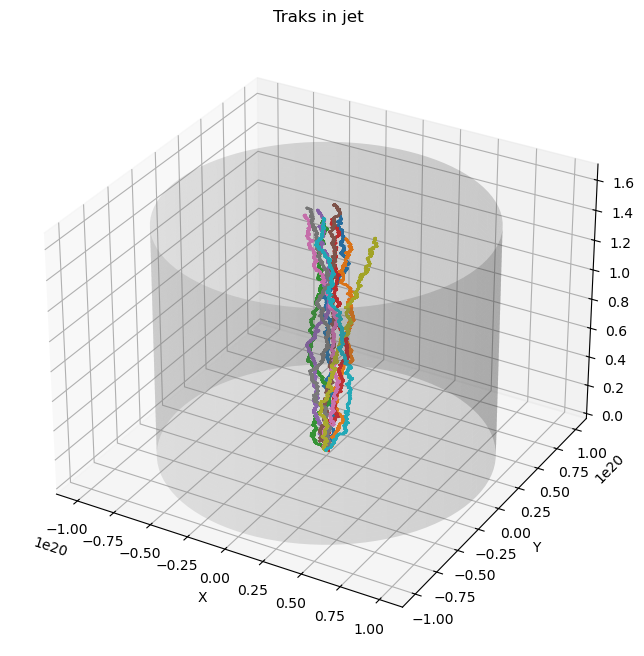

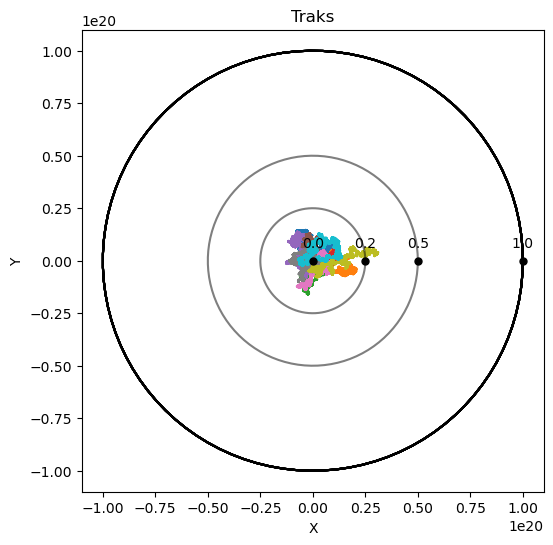

In [81]:
par_list = [0,10,100,500,600,1000,2000,3000,4000,4500]
R_c = R_sh  # 圆柱半径
R_d = R_sh  # 圆形半径

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(projection='3d')

for i in par_list:
    mask = (file6[i,:] < 10 * R_sh)
    cylinder_mask = mask & (file6[i, :]**2 + file7[i, :]**2 <= R_c**2)
    ax1.plot(file6[i, :][cylinder_mask], file7[i, :][cylinder_mask], file8[i, :][cylinder_mask], label='Data points')

    theta = np.linspace(0, 2 * np.pi, 100)
    z = np.linspace(file8[i, :][cylinder_mask].min(), file8[i, :][cylinder_mask].max(), 50)
    Theta, Z = np.meshgrid(theta, z)
# 设置标签
X_cyl = R_c * np.cos(Theta)
Y_cyl = R_c * np.sin(Theta)
ax1.plot_surface(X_cyl, Y_cyl, Z, alpha=0.2, color='gray', label='Cylinder')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Traks in jet')
plt.savefig(tar_dir + 'Column.png')

fig2, ax2 = plt.subplots(figsize=(6, 6))

for i in par_list:
    mask = (file6[i,:] < 10 * R_sh)
    circle_mask = mask & (file6[i, :]**2 + file7[i, :]**2 <= R_d**2)
    ax2.plot(file6[i, :][circle_mask], file7[i, :][circle_mask], label='traks')

    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = R_d * np.cos(theta)
    y_circle = R_d * np.sin(theta)
    ax2.plot(x_circle, y_circle,'k', label='Circle boundary')
concentric_radii = [ R_d / 4, R_d / 2 , r0] 
for r in concentric_radii:
    x_concentric = r * np.cos(theta)
    y_concentric = r * np.sin(theta)
    ax2.plot(x_concentric, y_concentric, 'k', alpha=0.5)
radii_to_label = concentric_radii + [R_d]  
for r in radii_to_label:
    ax2.plot([r], [0], 'ko', markersize=5) 
    ax2.text(r, 0.05 * R_d, f'{r/R_sh:.1f}', fontsize=10, ha='center', va='bottom')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Traks')
#ax2.legend()
ax2.set_aspect('equal')
plt.savefig(tar_dir + 'Radius.png')